# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

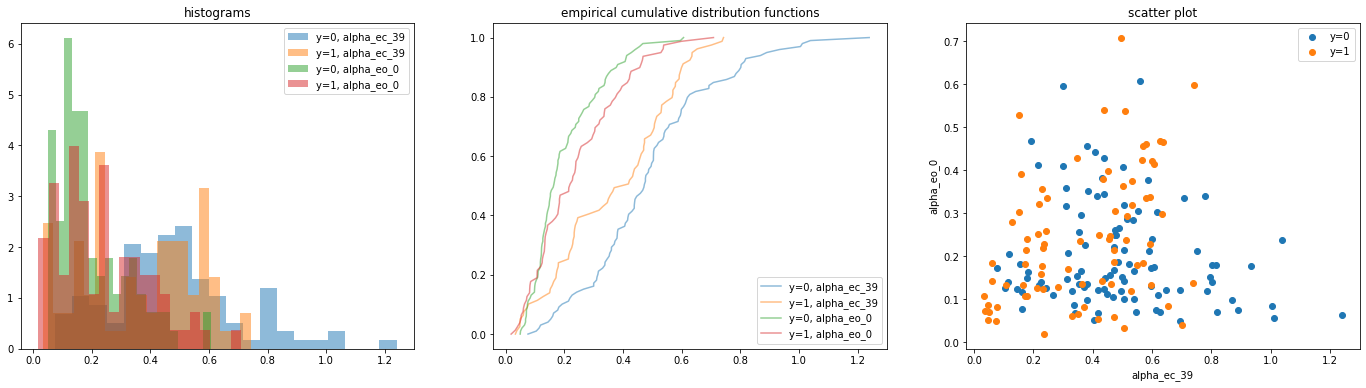

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [5]:
print(X.shape)
print(X[0].shape)
print(y.shape)

(180, 432)
(432,)
(180,)


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import KFold 

In [6]:
#defining a function to find accuracy of the test

def knn(X,y):
    #set number of neighbors to 3
    kn = KNeighborsClassifier(3)
    #set number of splits to 18
    cv = KFold(n_splits = 18, shuffle = False) # 

    #defining empty lists
    sensitivity, specificity, train_accuracy = [],[],[]
    y_test_actual, y_test_pred = [],[]

    #for loop to split data leaving one subject out
    for train_index, test_index in cv.split(X): # 2nd for loop for cross-validation
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        #print("X_train", X_train.shape,"y_train", y_train.shape,"X_test", X_test.shape,"y_test", y_test.shape)
        #print("train idex", train_index, "test index",test_index )

        #fitting data into knn classifier
        kn.fit(X_train,y_train)
        #predicting train data
        lr_train_pred = kn.predict(X_train)
        #finding sesitivity, specificity and accuracy of train data using confusion matrix
        true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_train, lr_train_pred).ravel()
        sensitivity.append(true_pos/(true_pos+false_neg))
        specificity.append(true_neg/(true_neg+false_pos))
        train_accuracy.append(accuracy_score(y_train,lr_train_pred))
        #test sample prediction
        lr_test_pred = kn.predict(X_test)
        y_test_actual.append(y_test)
        y_test_pred.append(lr_test_pred)


    y_test_actual = np.array(y_test_actual).ravel()
    y_test_pred = np.array(y_test_pred).ravel()
    #finding sesitivity, specificity and accuracy of test data using confusion matrix
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test_actual,y_test_pred).ravel()
    sensitivity_test = true_pos/(true_pos+false_neg)
    specificity_test = true_neg/(true_neg+false_pos)
    accuracy_test = accuracy_score(y_test_actual,y_test_pred)
    auc = roc_auc_score(y_test_actual,y_test_pred)

    print("Training score: ", np.mean(train_accuracy))
    print("Test score: ", accuracy_test)
    print("Accuracy: ", auc)


In [7]:
knn(X,y)

Training score::  0.9130718954248367
Test score: 0.7277777777777777
Accuracy:  0.7175


In [8]:
#import lasso
from sklearn.linear_model import Lasso

In [9]:
#define lasso with alpha value as 0.05
lasso = Lasso(alpha = 0.05)
#fitting data into lasso
lasso.fit(X,y)
x_new = X[:,lasso.coef_!=0]
print(x_new.shape)


(180, 11)


In [10]:
#finding accuracy using lasso
knn(x_new,y)

Training score::  0.8709150326797386
Test score: 0.75
Accuracy:  0.74


In [11]:
#function definig best number of neighbors of knn classifier
grid_params = {
    'n_neighbors' : [3,5,7,9,11,13,15]
}
gs = GridSearchCV(
        KNeighborsClassifier(),
    grid_params,
    cv = 3,
    n_jobs = -1
)
gs_results = gs.fit(X,y)
print(gs_results.best_params_)

{'n_neighbors': 3}


In [12]:
#function defining best alpha value for lasso
grid_params = {
    'alpha' : np.arange(0,1,0.01)
}
gs = GridSearchCV(
        Lasso(),
    grid_params,
    cv = 7,
    n_jobs = -1
)
gs_results = gs.fit(X,y)
print(gs_results.best_params_)

{'alpha': 0.02}
